In [1]:
import pandas as pd
import numpy as np
import string
import re
import torch
import dill
import warnings
warnings.filterwarnings("ignore")
import fasttext
import seaborn as sns
import matplotlib.pyplot as plt
from contractions import fix
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [2]:
df=pd.read_csv("Toxic&Sentiment_Dataset.csv")

In [3]:
df

,comment_text,toxic,positive,negative,neutral
0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,0,1,0
1,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,1,0
2,"Bye! \n\nDon't look, come or think of comming ...",1,0,1,0
3,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0
4,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,1,0
...,...,...,...,...,...
201076,you are shit,1,0,1,0
201077,you are full of shit,1,0,1,0
201078,you are full of crap,1,0,1,0
201079,you are mental,1,0,0,0


In [4]:
LEMMATIZER= WordNetLemmatizer()

# PREPROCESSING

In [5]:
def Remove_Punctuation(text):
    Punctuations=string.punctuation
    return text.translate(str.maketrans('','',Punctuations))

def Remove_UnWanted_Character(text):
    text = re.sub(r"http[s]?://\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"<[^>]*>", "", text)  # Remove HTML tags
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "", text)# Remove email addresses
    text = re.sub("you", "", text) 
    text = re.sub("[0-9]", "", text)  # Remove all digits
    text = re.sub(r"@\w+", "", text)  # Remove mentions (e.g., @username)
    text = re.sub(r"\b(\w)\1+\b", "", text)  # Remove repeated single-character words (e.g., "aaaaa")
    text = re.sub(r"[^\x00-\x7f]+", " ", text)  # Remove non-ASCII characters
    text = re.sub(rf"\b\w{{{30},}}\b", " ", text)  # Remove words longer than 30 characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces and trim
    return text
    

def LEMMATIZATION(text):
    return " ".join([LEMMATIZER.lemmatize(words,pos="a") for words in text.split()])

def Exapanding_Contractions(text):
    return fix(text)



In [6]:
df.dropna(inplace=True)
df[df.columns[0]].dropna(inplace=True)
df[df.columns[0]]=df[df.columns[0]].astype(str)
df['Cleaned_Comment']=df[df.columns[0]].str.lower()
df['Cleaned_Comment']=df['Cleaned_Comment'].apply(lambda x: Remove_Punctuation(x))
df['Cleaned_Comment']=df["Cleaned_Comment"].apply(lambda x: Remove_UnWanted_Character(x))
df['Cleaned_Comment']=df['Cleaned_Comment'].apply(lambda x: Exapanding_Contractions(x))
df['Cleaned_Comment']=df['Cleaned_Comment'].apply(lambda x: LEMMATIZATION(x))
df.replace("nan", pd.NA, inplace=True)
df.dropna(inplace=True)

# EXPLORATORY ANALYSIS

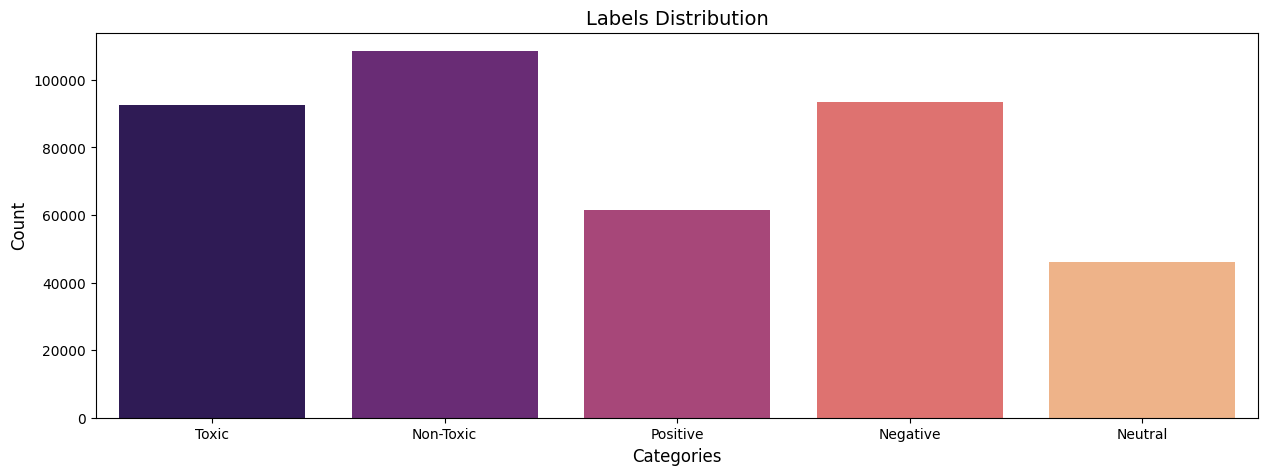

In [9]:
toxic=len(df[df.toxic==1])
Ntoxic=len(df[df.toxic==0])
positive=len(df[df.positive==1])
Npositive=len(df[df.positive==0])
negative=len(df[df.negative==1])
Nnegative=len(df[df.negative==0])
neutral=len(df[df.neutral==1])
Nneutral=len(df[df.neutral==0])

categories = ["Toxic", "Non-Toxic", "Positive", "Negative","Neutral"]
counts = [toxic, Ntoxic, positive, negative, neutral,]

plt.figure(figsize=(15, 5))
sns.barplot(x=categories, y=counts, palette="magma"
)

plt.xlabel("Categories",fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Labels Distribution", fontsize=14)
plt.savefig("LabelDistribution.png")
plt.show()


![](toxic_words.png)
![](positive_words.png)

![](negative_words.png)
![](neutral_words.png)

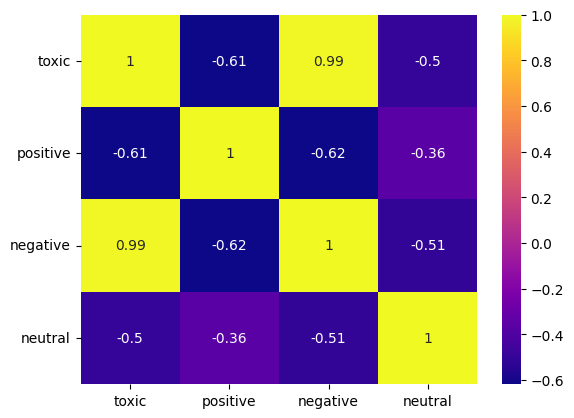

In [9]:
sns.heatmap(df[df.columns[1:5]].corr(),cmap='plasma',annot=True)
plt.yticks(rotation=360)
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight') 
plt.show()

# FEATURE EXTRACTION - Fasttext 

![](fatsttext.png)

In [13]:
def Get_Embeddings(text):
    words = text.split()
    
    if not words:
        return np.zeros(Emodel.get_dimension())

    word_embeddings = np.array([Emodel.get_word_vector(word) for word in words])

    sentence_embedding = np.mean(word_embeddings, axis=0)

    return sentence_embedding


In [15]:
#model=fasttext.train_unsupervised("Comments#1.txt",model="skipgram",dim=300)
Emodel=fasttext.load_model("Embedding.bin")

ValueError: Embedding.bin cannot be opened for loading!

In [10]:
x=df['Cleaned_Comment'].apply(lambda x:np.array(Get_Embeddings(x)))
x = np.vstack(x.values)

In [11]:
target=df[df.columns[1:5]]
x_train,x_test,y_train,y_test=train_test_split(x,target, test_size=0.2, random_state=42 , shuffle=True)

# Model Building & Prediction

In [17]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score,classification_report

In [ ]:
LR = LogisticRegression(
    C=3.0,                
    max_iter=500,         
    penalty='elasticnet', 
    solver='saga',        
    l1_ratio=0.5,         
    n_jobs=-1,           
    fit_intercept=True,   
    class_weight='balanced',  
    random_state=42      
)

XGB=XGBClassifier(n_estimators=1000, use_label_encoder=False, eval_metric='logloss',n_jobs=-1)

Voting_Model= VotingClassifier(
    estimators=[
        ('Logistic Regression', LR),
        ('XGBoost', XGB)
    ],
    voting='soft'  
)

### LOGISTIC REGRESSION

![](LR.png)

In [ ]:
LR_model = ClassifierChain(base_estimator=LR, order='random', random_state=42)
LR_model.fit(x_train,y_train)
LR_pred=LR_model.predict(x_test)
print()
print("TRAINING : ", LR_model.score(x_train,y_train))
print("TESTING : ", LR_model.score(x_test,y_test))
print()
print("LR ACCURACY : ", accuracy_score(y_test,LR_pred))

##  XGBOOST CLASSIFIER

![XGBOOST CLASSIFIER](xgboost.png)

In [ ]:
XGB_Model= ClassifierChain(base_estimator=LR, order='random', random_state=42)
XGB_Model.fit(x_train,y_train)
XGB_pred=XGB_Model.predict(x_test)
print()
print("TRAINING : ", XGB_Model.score(x_train,y_train))
print("TESTING : ", XGB_Model.score(x_test,y_test))
print()
print("LR ACCURACY : ", accuracy_score(y_test,XGB_pred))
print()


## VOTING CLASSIFIER

![](voting.png)

In [ ]:
voting_clf=ClassifierChain(base_estimator=Voting_Model, order='random', random_state=42)
voting_clf.fit(x_train, y_train)
y_pred1 = voting_clf.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
print("Classification Report:\n", classification_report(y_test, y_pred1))


# EVALUATION & FINDINGS 

In [51]:
with open("FusionBoostModelX.pkl", "rb") as f:
    FusionBoost = dill.load(f)
    
def Predictions(x):
    pred=(FusionBoost.predict(x) > 0.5).astype(int)[0]
    return pred[0],pred[1],pred[2],pred[3]
    

def Eval():
    edf=df.sample(20000).copy()
    edf.dropna(inplace=True)
    sampled_indices = edf.index  
    target = df.loc[sampled_indices,['toxic', 'positive', 'negative', 'neutral']] 
    edf[edf.columns[0]].dropna(inplace=True)
    edf[edf.columns[0]]=edf[edf.columns[0]].astype(str)
    edf['Cleaned_Comment']=edf[df.columns[0]].str.lower()
    edf['Cleaned_Comment']=edf['Cleaned_Comment'].apply(lambda x: Remove_Punctuation(x))
    edf['Cleaned_Comment']=edf["Cleaned_Comment"].apply(lambda x: Remove_UnWanted_Character(x))
    edf['Cleaned_Comment']=edf['Cleaned_Comment'].apply(lambda x: Exapanding_Contractions(x))
    edf['Cleaned_Comment']=edf['Cleaned_Comment'].apply(lambda x: LEMMATIZATION(x))
    edf.replace("nan", pd.NA, inplace=True)
    pred= edf['Cleaned_Comment'].apply(lambda x: pd.Series(Predictions(x)))
    pred.columns = ['toxic', 'positive', 'negative', 'neutral']
    print()
    print(f"ACCURACY :  {accuracy_score(target,pred)*100}%")
    print("Classification Report : ")
    print(classification_report(target,pred))
    print()
    for i, label in enumerate(target.columns):
        cm=confusion_matrix(target.iloc[:, i], pred.iloc[:, i])
        cmDisp=ConfusionMatrixDisplay(cm)
        cmDisp.plot()
    print()

In [ ]:
Eval()

### WORD REPRSENTATION
![](Experiment_fasttext.jpeg)

In [22]:
Emodel.get_nearest_neighbors("human")

[(0.8556137681007385, 'humane'),
 (0.838182270526886, 'inhuman'),
 (0.8330483436584473, 'huma'),
 (0.822429895401001, 'nonhuman'),
 (0.747660219669342, 'subhuman'),
 (0.6631761193275452, 'humanity'),
 (0.6521159410476685, 'inhumane'),
 (0.6482937335968018, 'subhumans'),
 (0.6232922077178955, 'humanrights'),
 (0.600135326385498, 'humanitarian')]

In [12]:
print()
print()
text="i am better at this" 
print("BEFORE : ",text)
print()
text=LEMMATIZATION(text)
print("AFTER : ",text)
print()
print()



BEFORE :  i am better at this

AFTER :  i am good at this


